In [97]:
import cProfile
import os
import pickle
import pstats
import re
from collections import namedtuple
from typing import List
from multiprocessing import Pool
import networkx as NX
import pandas as pds
import matplotlib.pyplot as plt
import itertools
import math
import re
import statistics
from pprint import pprint

import scipy
from scipy import stats as scistats
from sklearn import linear_model, preprocessing
from tabulate import tabulate
from pathlib import Path
import pickle
import random
import argparse
import sys
from db_actions import db_actions
import numpy as np
from my_yaml import yaml_load, yaml_dump
from alive_progress import alive_bar
import seaborn as sns


In [98]:
TR = namedtuple('TableRow', ["cluster", "wfName", "method", "res"])
BigTR = namedtuple("BigTableRow", ["regModel", "cluster", "clusterSize", "wfName", "method", "res", "schedCat", "schedType"])
CVBigTR = namedtuple("CVBigTableRow", ["regModel", "cluster", "clusterSize", "wfName", "method", "res", "schedCat", "schedType", "cvSplit"])

In [99]:
def list_compare(a, b):
    if type(a) != type(b):
        return False
    if type(a) != list:
        return a == b
    if len(a) != len(b):
        return False
    for a_, b_ in zip(a, b):
        if not list_compare(a_, b_):
            return False
    return True


def load_from_file(f):
    modelDegLUT = {
        'linModel' : 1,
        'quadModel': 2,
        'cubeModel': 3,
        'tetModel' : 4,
        'penModel' : 5
    }
    shorterMethodNamesLUT = {
        'randomScheduler'     : 'random',
        'recommenderScheduler': 'recommender'
    }
    shortToLongNameLUT = {'Linear'       : 'Ordinary Least Squares',
                          'SVR-linear'   : 'SVR - linear',
                          'SVR-poly'     : 'SVR - poly',
                          'SVR-rbf'      : 'SVR - rbf',
                          'SVR-sigmoid'  : 'SVR - sigmoid',
                          'Lasso'        : 'Lasso',
                          'LassoCV'      : 'Lasso CV',
                          'Ridge'        : 'Ridge',
                          'RidgeCV'      : 'Ridge CV',
                          'ElasticNet'   : 'Elastic Net',
                          'ElasticNetCV' : 'Elastic Net CV',
                          'BayesianRidge': 'Bayesian Ridge',
                          'ARD'          : 'Automatic Relevance Determination',
                          'SGD'          : 'Stochastic Gradient Descent',
                          'PA'           : 'Passive Aggressive',
                          'Huber'        : 'Huber',
                          'TheilSen'     : 'Theil Sen'}
    #
    pFile = Path(f)
    with open(pFile, "br") as tmp:
        pl = pickle.load(tmp)
    #
    shortName = re.match("(.*/)*(.*?)\.recSchedTimes\.pickle", f).group(2)
    isCV = shortName[0:2] == "CV"
    if isCV:
        shortName = shortName.replace("CV", "")
    modelDeg = modelDegLUT[shortName.split(".")[0]]
    modelName = shortName.split('.')[1]
    if isCV:
        modelName, cvSplit = modelName.split("_")
    modelName = shortToLongNameLUT[modelName]
    shortName = f"{modelDeg} / {modelName}"
    for pre, deg in modelDegLUT.items():
        if pre in shortName:
            shortName = shortName.replace(pre + ".", f"{deg}/")
            break
    if isCV:
        fmt = CVBigTR
    else:
        fmt = BigTR
    for clusterName, cluster in pl.items():
        for wfName, wf in cluster.items():
            wfShortName = re.match("nfcore/(.*):.*", wfName).group(1)
            for methodName, res in wf.items():
                for longN, rep in shorterMethodNamesLUT.items():
                    if longN in methodName:
                        mName = methodName.replace(longN, rep)
                        break
                rowInfo = {
                    "regModel"   : shortName,
                    "cluster"    : clusterName,
                    "clusterSize": len(clusterName),
                    "wfName"     : wfShortName,
                    "method"     : mName,
                    "schedCat"   : "recommenderV1,-H1,-H2,-H3" if "V1" in mName else "recommenderV2,-H1,-H2,-H3",
                    "schedType"  : mName
                }
                if isCV:
                    rowInfo["cvSplit"] = cvSplit
                if type(res) != list:
                    rowInfo["res"] = float(res)
                    yield fmt(**rowInfo)
                else:
                    rowInfo["regModel"] = "N/A"
                    rowInfo["schedCat"] = "random"
                    rowInfo["schedType"] = "random"
                    for i, r in enumerate(res):  # this only applies to the results of the randomScheduler(V1)
                        rowInfo["method"] = mName + f"P{i * 10}"
                        rowInfo["res"] = float(r)
                        yield fmt(**rowInfo)
                    rowInfo["method"] = mName + "Avg"
                    rowInfo["res"] = float(statistics.mean(res))
                    yield fmt(**rowInfo)


def load_from_dir(d):
    with alive_bar(len(os.listdir(d)), f"Loading recommenderScheduler results from {d}") as bar:
        for f in os.listdir(d):
            yield from load_from_file(f"{d}/{f}")
            bar()



In [100]:
def get_bigtable(saveLoc, btFileLoc):
    btFile = Path(btFileLoc)
    if not btFile.is_file():
        data = list(load_from_dir(saveLoc))
        bigtable = pds.DataFrame(data, columns=data[0]._fields)
        with open(btFile, "bw") as f:
            pickle.dump(bigtable, f)
    else:
        with open(btFile, "br") as f:
            bigtable = pickle.load(f)
    return bigtable

In [101]:
def save_plot(obj, name, loc="./fig/"):
    obj.savefig(f"{loc}{name}.pdf", transparent=True)
    obj.savefig(f"{loc}{name}.png", transparent=True)

# Get the recSchedTimes data

In [102]:
bigtable = get_bigtable("recSchedTimes", "./recSchedBigTable.pickle")  #.sample(frac=5 / 100, random_state=0, axis=0)

In [103]:
wfNames = bigtable.wfName.unique()

In [104]:
sns.set_theme(style="whitegrid")
#sns.set_context("paper")
sns.set_context("paper", 1.65)

In [105]:
pds.set_option('display.max_rows', 100)
pds.set_option('display.max_columns', None)
pds.set_option('display.width', None)
pds.set_option('display.precision', 4)


In [106]:
descByMethod = bigtable.groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
descByMethod.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# descByMethod

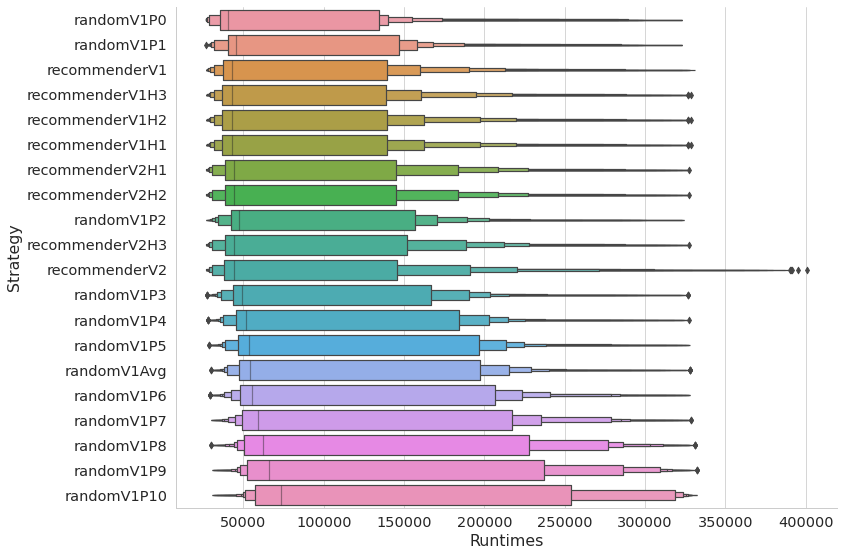

In [107]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=descByMethod.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=bigtable,
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    save_plot(g, f"res_Vs_method_{style}.plot")
    plt.show()

In [108]:
descByModel = bigtable[bigtable.regModel != "N/A"].groupby(["regModel"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
descByModel.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# descByModel

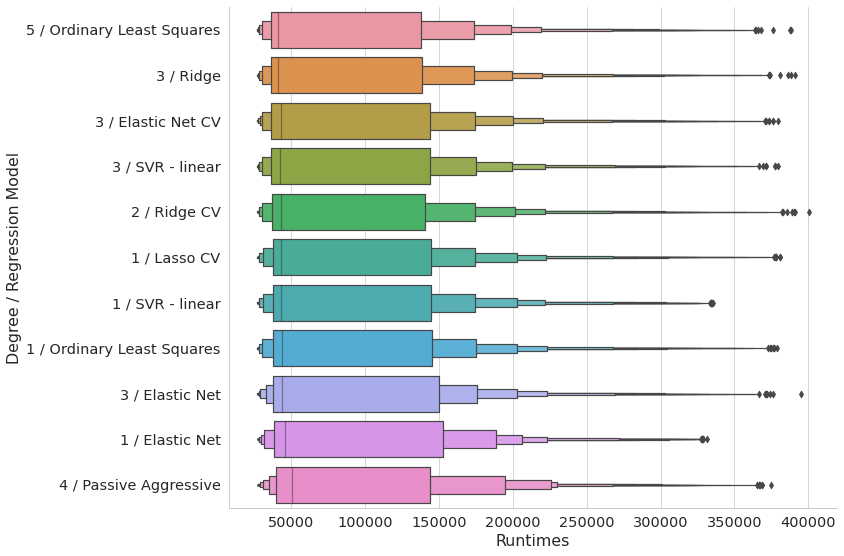

In [109]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=descByModel.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=bigtable[bigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    save_plot(g, f"res_Vs_regModel_{style}.plot")
    plt.show()

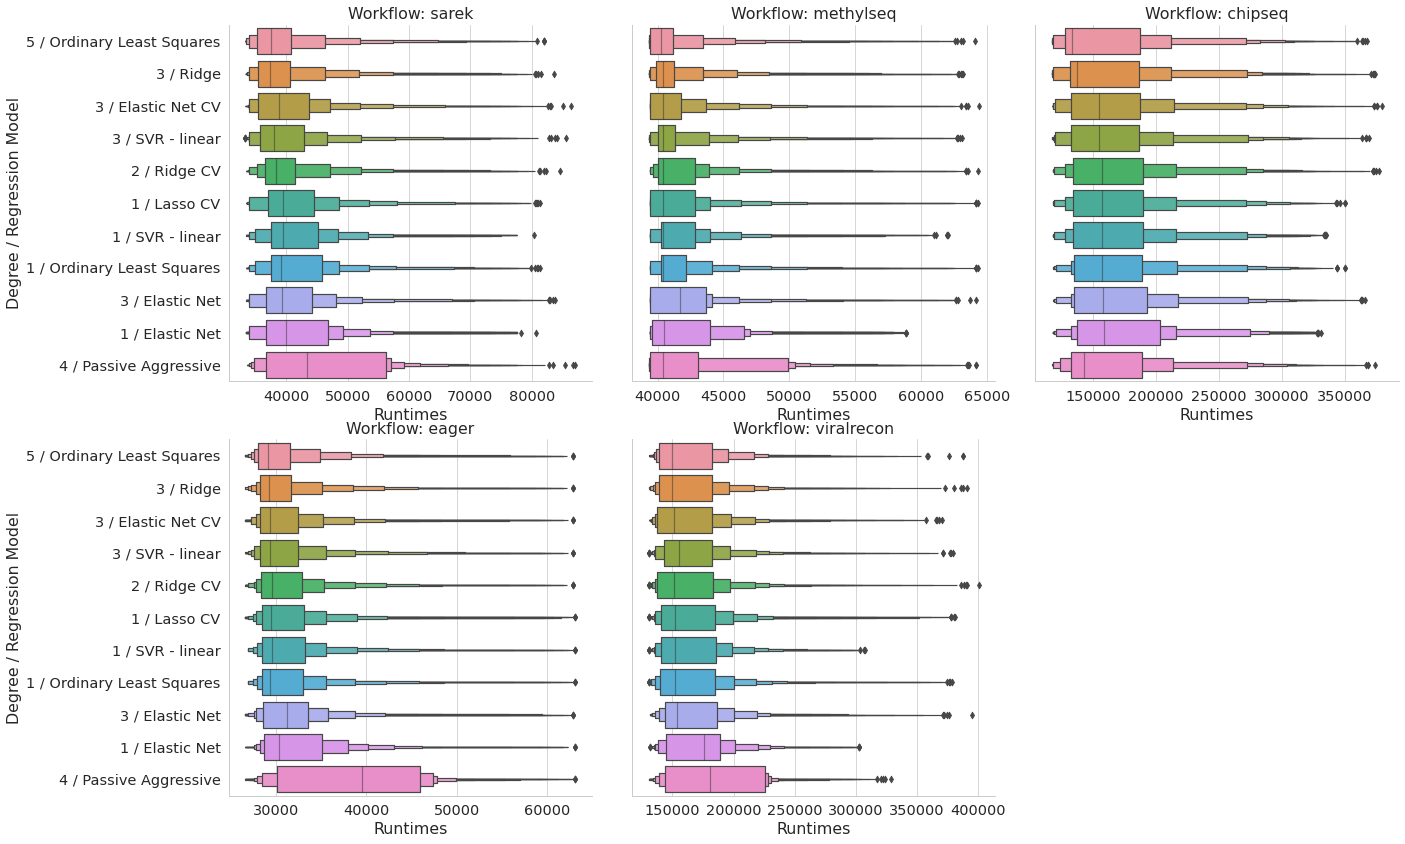

In [110]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=descByModel.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=bigtable[bigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"res_Vs_method_perWF_{style}.plot")
    plt.show()

# Filter for only the BiS regression model:

In [111]:
bisModel = descByModel.index[0]
bigtable = bigtable.query("schedType == 'random' or regModel==@bisModel")

In [112]:
descByMethodSansRand = bigtable[bigtable.regModel != "N/A"].groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
descByMethodSansRand.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)

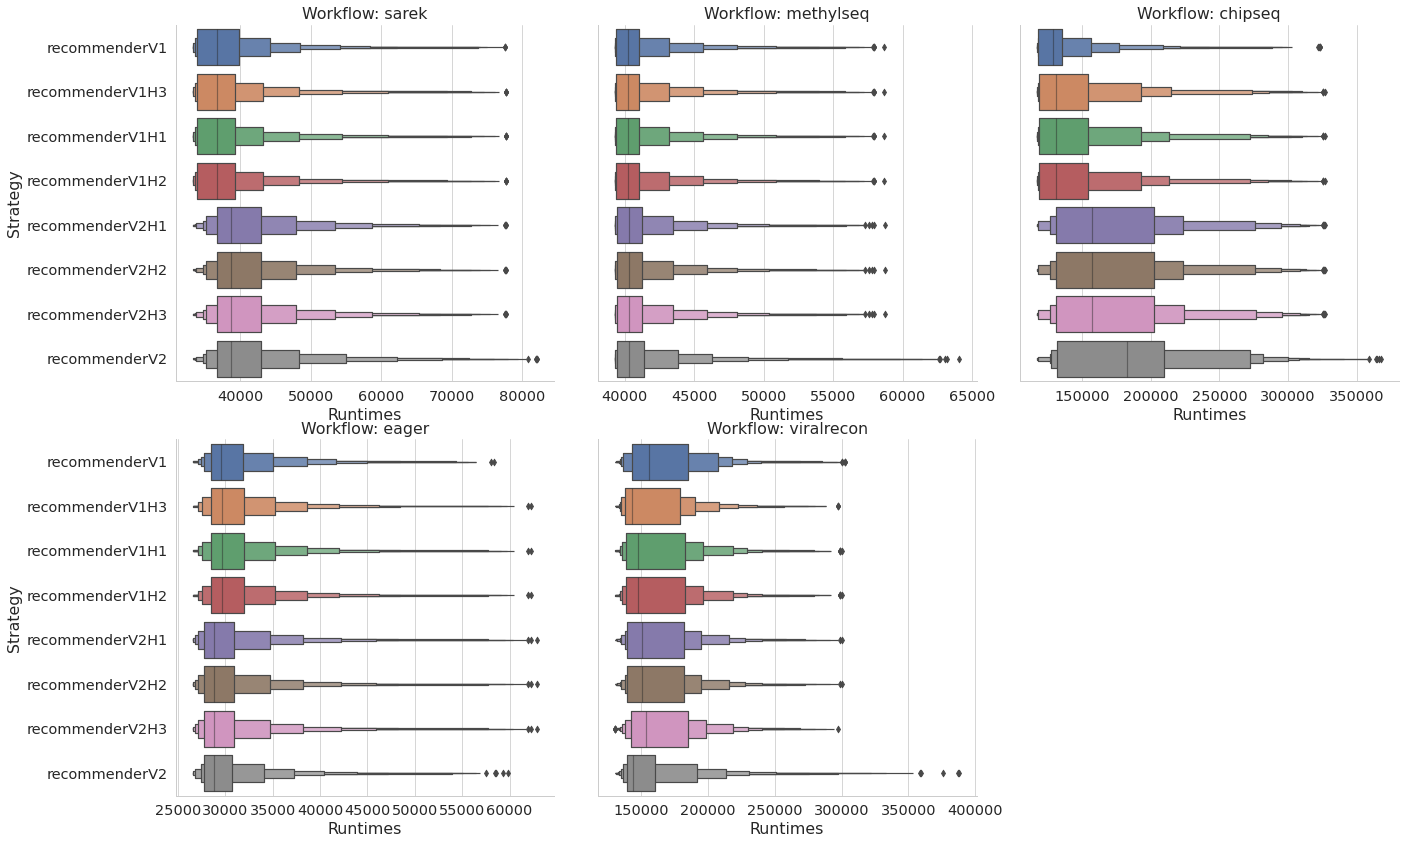

In [113]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=descByMethodSansRand.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=bigtable[bigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"res_Vs_method_bisModel_{style}.plot")
    plt.show()

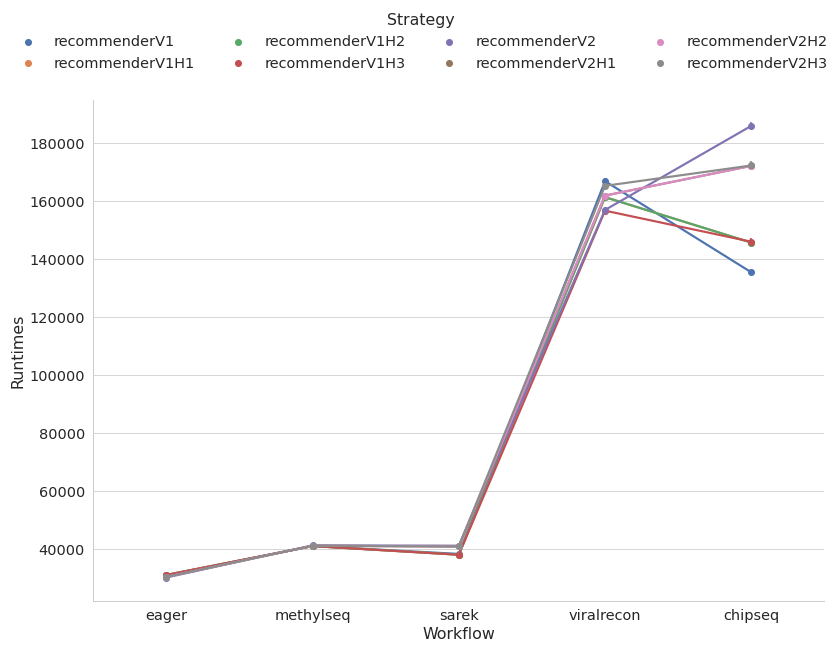

In [114]:
g = sns.catplot(x="wfName", y="res",  # orient="h",
                order=["eager", "methylseq", "sarek", "viralrecon", "chipseq"],
                hue="method",  # palette=["m", "g"],
                hue_order=["recommenderV1", "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2", "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # row="wfName",
                # col="wfName",
                # col_wrap=3,
                data=bigtable[bigtable.schedCat != "random"],
                kind="point",
                aspect=1.5,
                height=8,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.425, 1), ncol=4, title="Strategy", frameon=False)
g.set(xlabel="Workflow", ylabel="Runtimes")
save_plot(g, "res_Vs_method_bisModel_Point.plot")
plt.show()

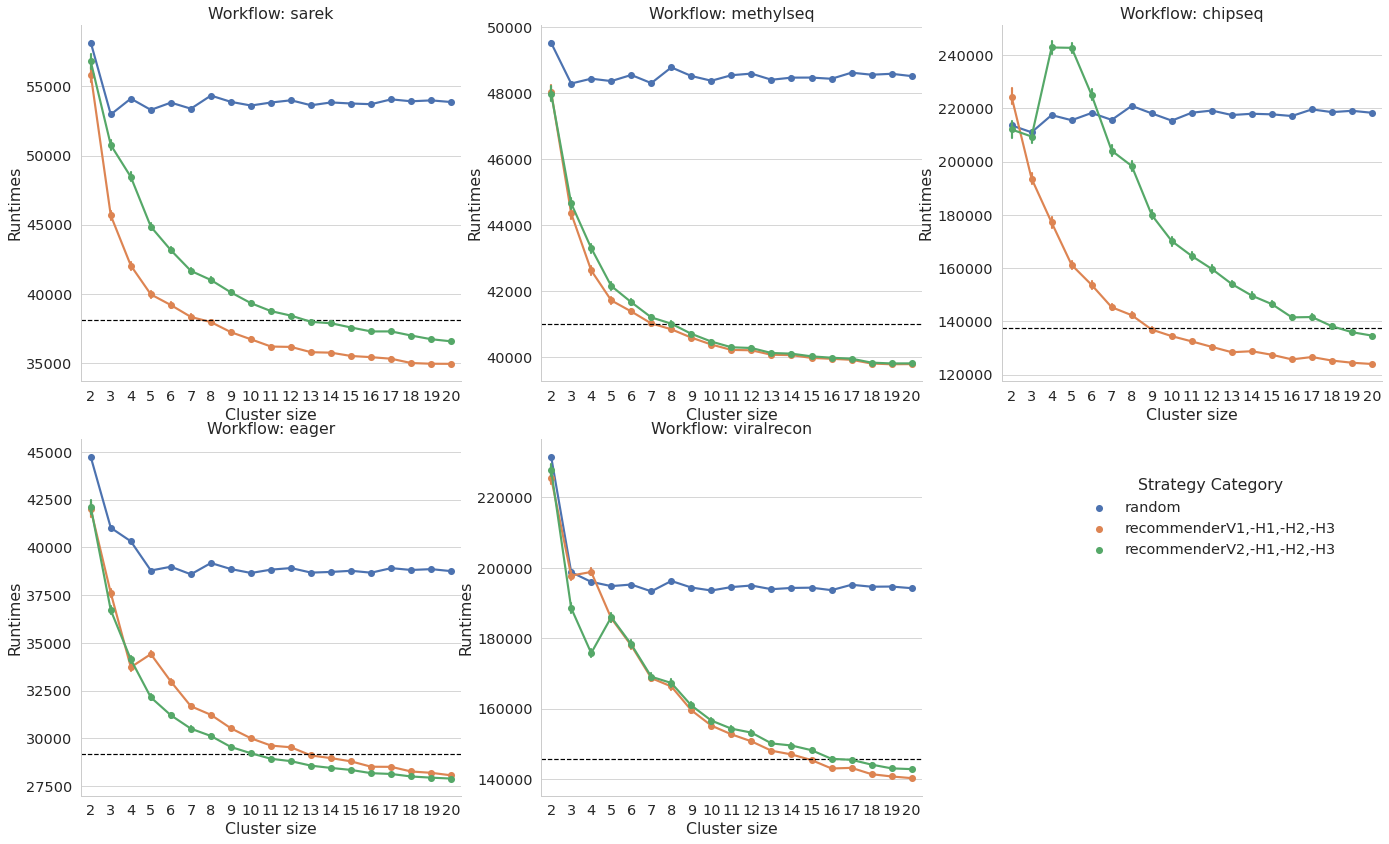

In [115]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="schedCat",  # palette=["m", "g"],
                # row="wfName",
                col="wfName",
                col_wrap=3,
                col_order=list(wfNames),
                sharey=False,
                sharex=False,
                data=bigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "upper left", bbox_to_anchor=(.65, .45), title="Strategy Category", frameon=False)
for i, ax in enumerate(g.axes.ravel()):
    wf = list(wfNames)[i]
    ax.axhline(y=statistics.mean(bigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), linestyle="--", color="black")
g.set_titles("Workflow: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "res_Vs_clusterSize_perWF_bisModel_hueSchedCat_Point.plot")
plt.show()

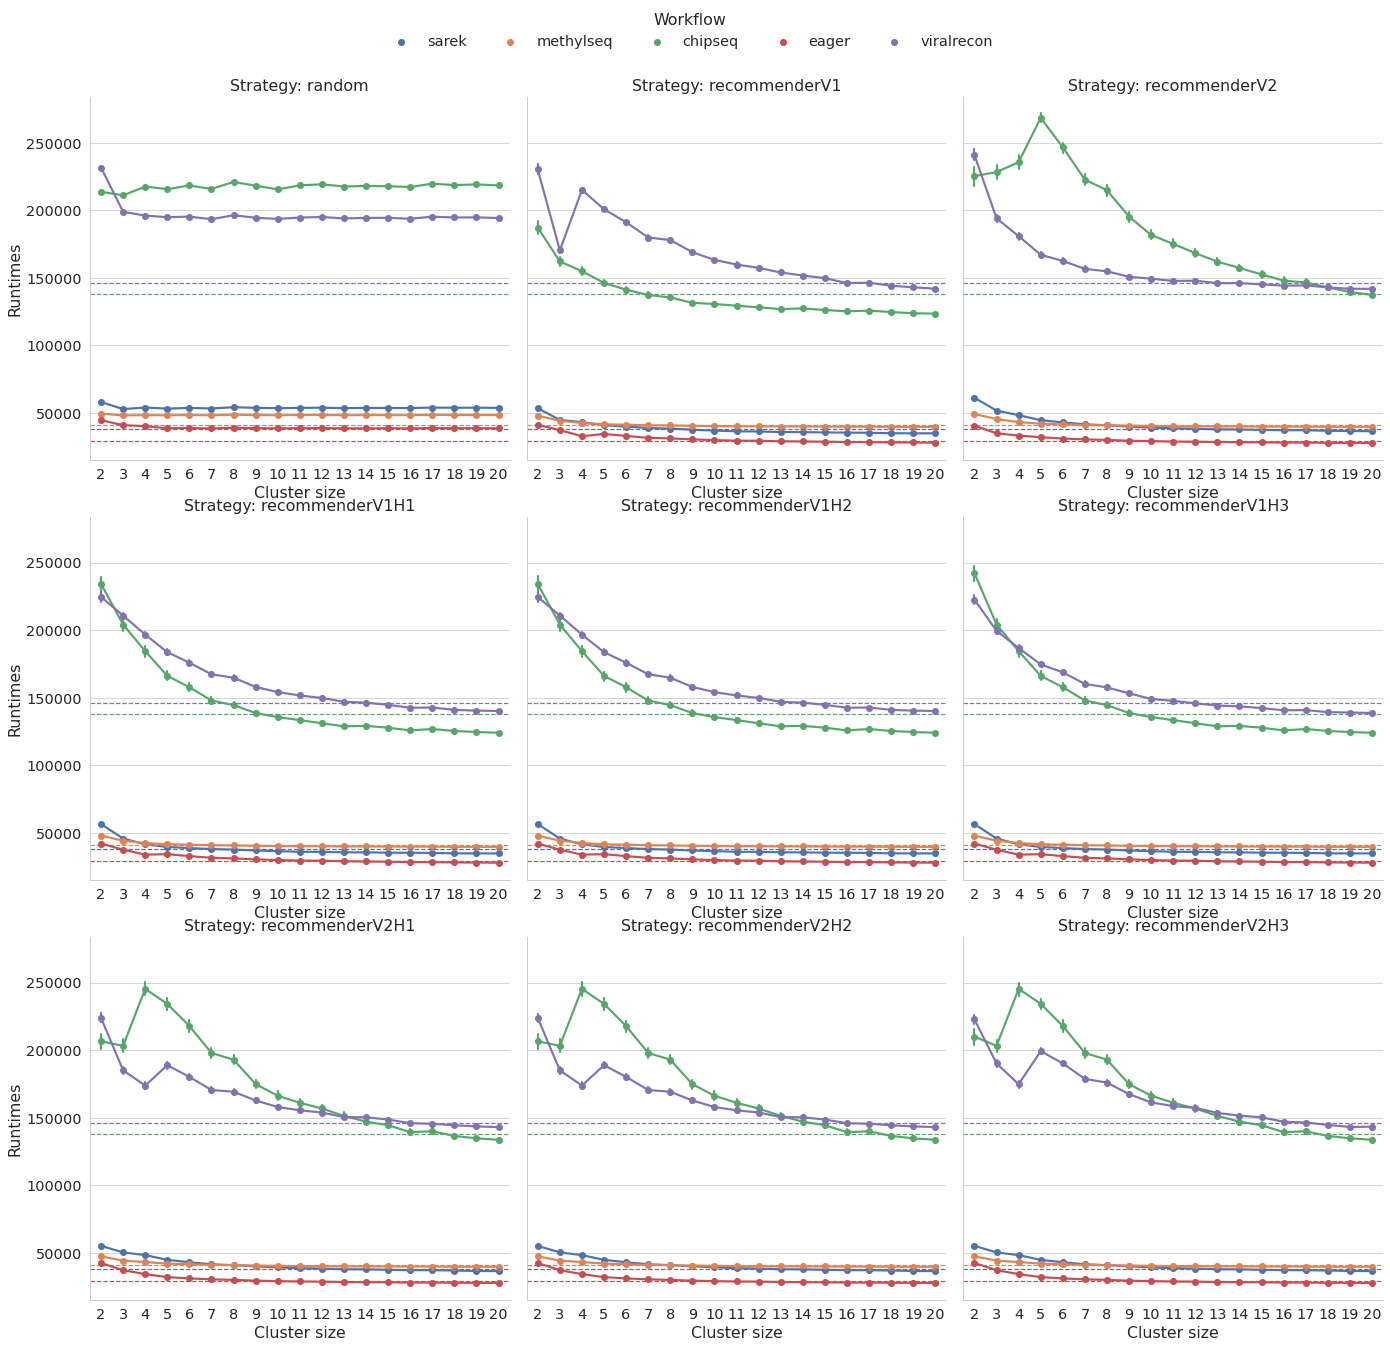

In [116]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="wfName",  # palette=["m", "g"],
                # row="wfName",
                col="schedType",
                col_wrap=3,
                col_order=["random", "recommenderV1", "recommenderV2",
                           "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # sharey=False,
                sharex=False,
                hue_order=list(wfNames),
                data=bigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.45, 1), ncol=5, title="Workflow", frameon=False)
for i, wf in enumerate(wfNames):
    g.refline(y=statistics.mean(bigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), color=sns.color_palette()[i])
g.set_titles("Strategy: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "res_Vs_clusterSize_perMethod_bisModel_hueWf_Point.plot")
plt.show()


# Get the cvRecSchedTimes data

In [132]:
cvBigtable = get_bigtable("cvRecSchedTimes", "./cvRecSchedBigTable.pickle")  #.sample(frac=5 / 100, random_state=0, axis=0)
# cvBigtable

In [118]:
wfNames = cvBigtable.wfName.unique()

In [119]:
sns.set_theme(style="whitegrid")
#sns.set_context("paper")
sns.set_context("paper", 1.65)

In [120]:
pds.set_option('display.max_rows', 100)
pds.set_option('display.max_columns', None)
pds.set_option('display.width', None)
pds.set_option('display.precision', 4)

In [121]:
cvDescByMethod = cvBigtable.groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
cvDescByMethod.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# cvDescByMethod

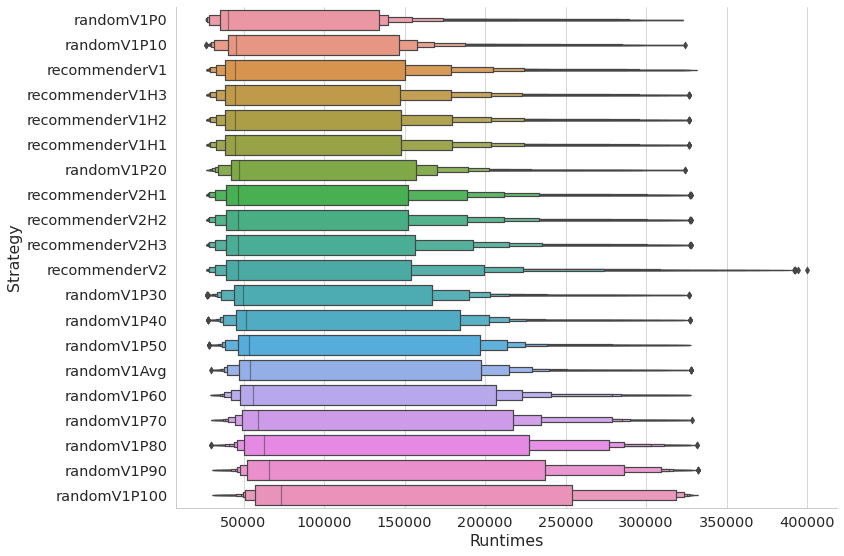

In [122]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=cvDescByMethod.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=cvBigtable,
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    save_plot(g, f"res_Vs_method_{style}.plot")
    plt.show()

In [123]:
cvDescByModel = cvBigtable[cvBigtable.regModel != "N/A"].groupby(["regModel"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
cvDescByModel.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# cvDescByModel

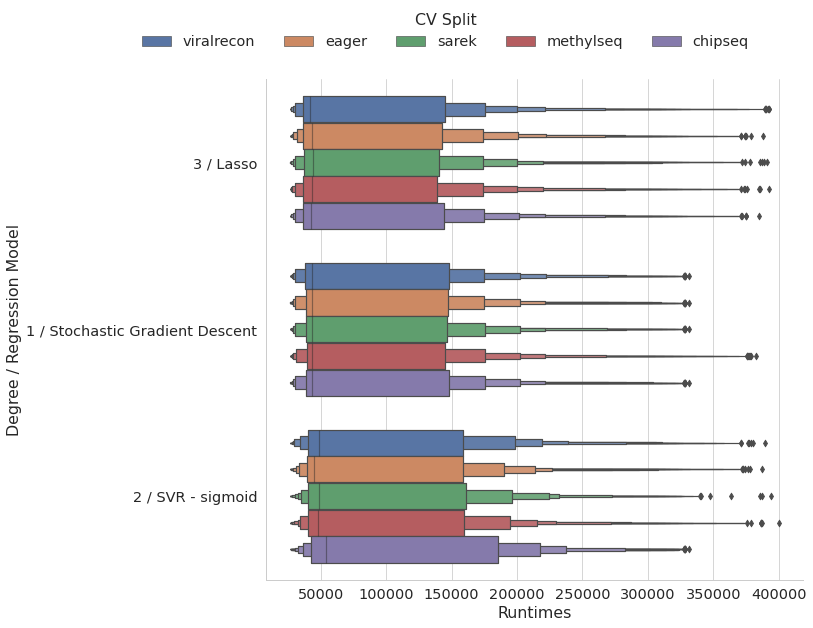

In [133]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=cvDescByModel.index,
                    hue="cvSplit",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=cvBigtable[cvBigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    sns.move_legend(g, "lower center", bbox_to_anchor=(0.5, 1), ncol=5, title="CV Split")
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    save_plot(g, f"cv.res_Vs_regModel_{style}.plot")
    plt.show()

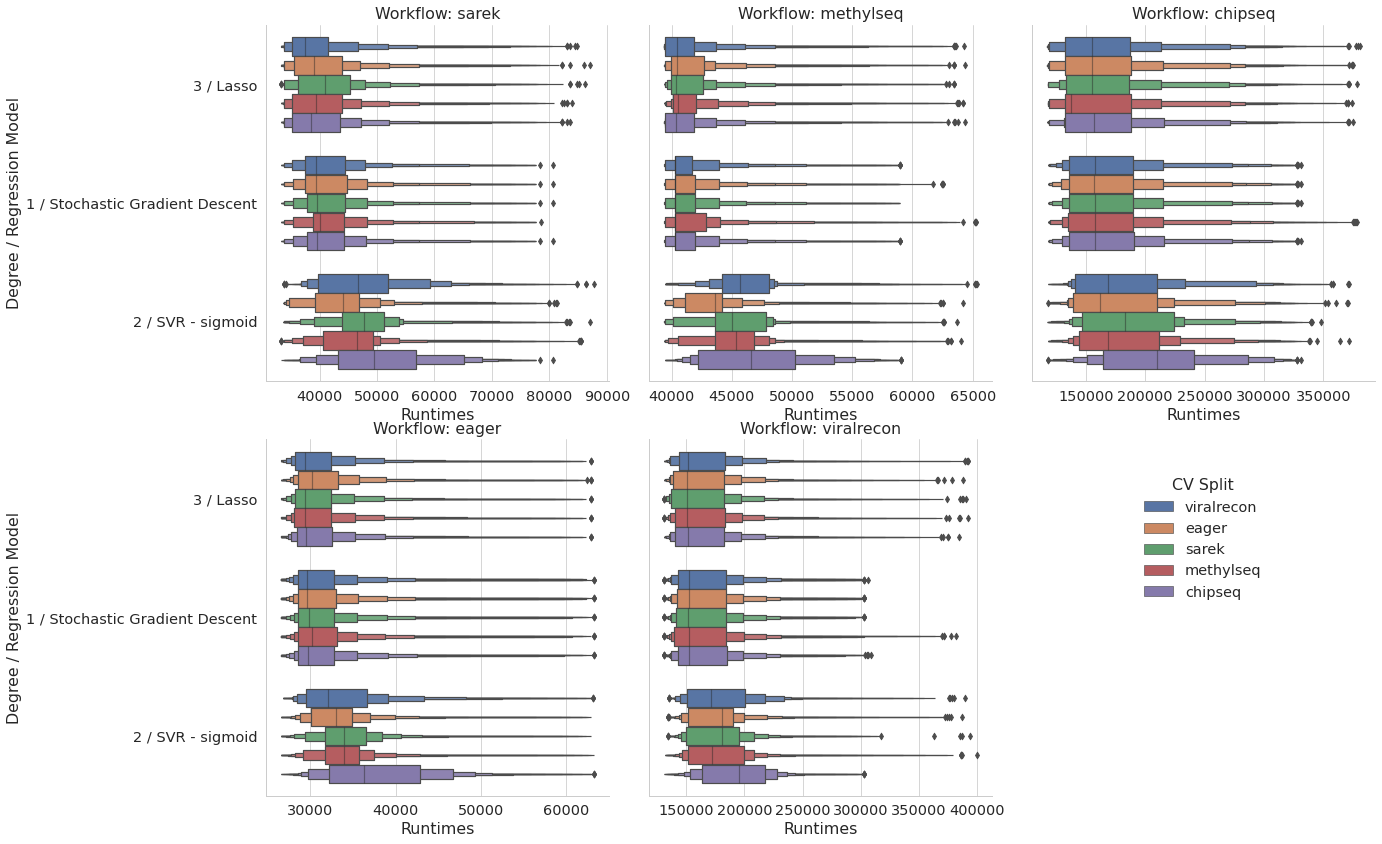

In [125]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=cvDescByModel.index,
                    hue="cvSplit",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=cvBigtable[cvBigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    sns.move_legend(g, "upper left", bbox_to_anchor=(0.75, 0.45), title="CV Split")
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"cv.res_Vs_method_perWF_{style}.plot")
    plt.show()

# Filter for only the BiS regression model:

In [126]:
# bisModel = descByModel.index[0]
comp = cvBigtable[cvBigtable.regModel != "N/A"].groupby(["regModel", "cvSplit"])["res"].describe()
comp = comp.sort_values(by=["mean"], ascending=True)
rM, cvS = comp.reset_index().iloc[0][["regModel", "cvSplit"]]
cvBigtable = cvBigtable.query("schedType == 'random' or (regModel==@rM and cvSplit==@cvS)")

In [127]:
cvDescByMethodSansRand = cvBigtable[cvBigtable.regModel != "N/A"].groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
cvDescByMethodSansRand.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)

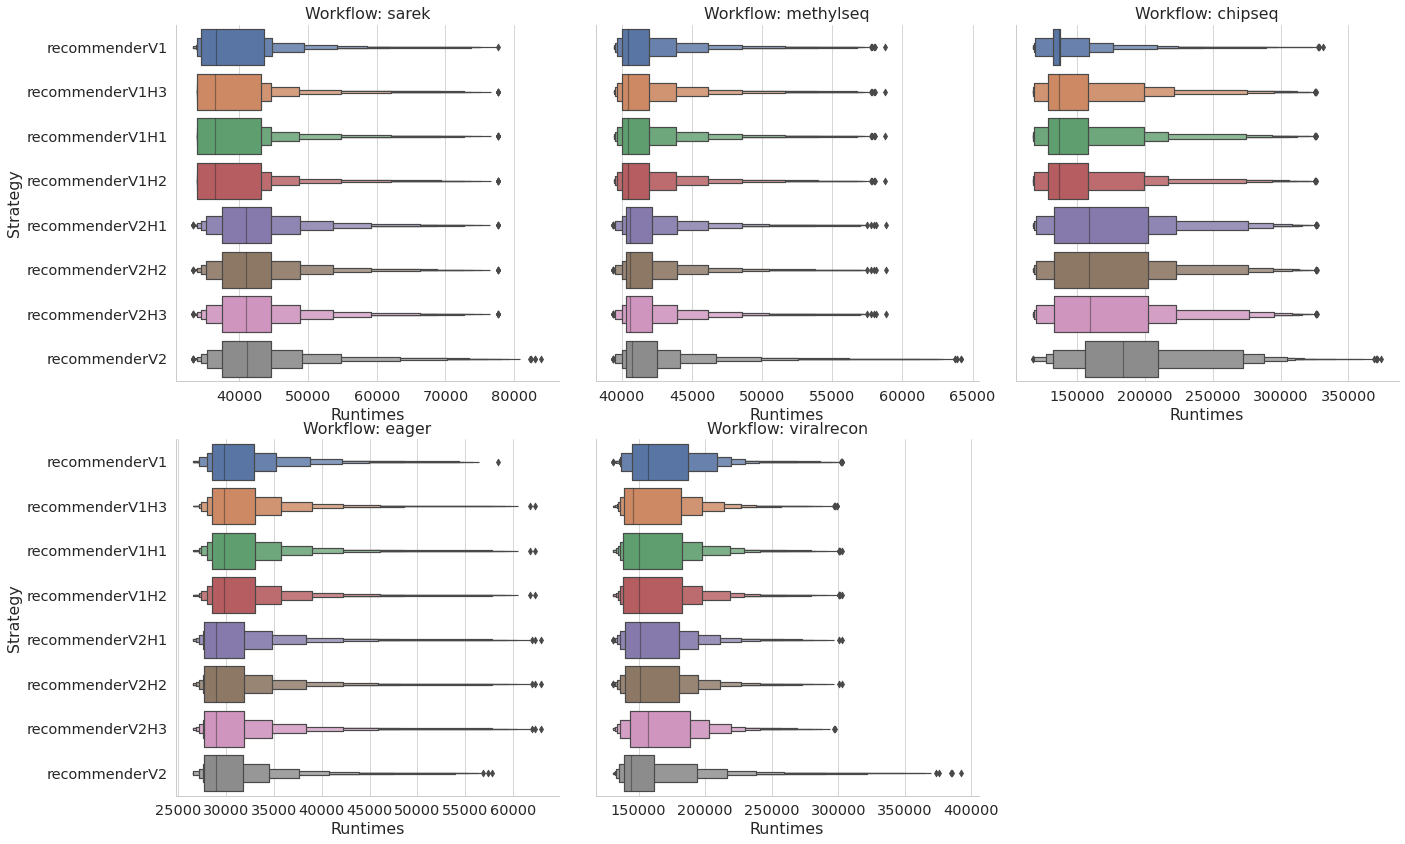

In [128]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=cvDescByMethodSansRand.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=cvBigtable[cvBigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"cv.res_Vs_method_bisModel_{style}.plot")
    plt.show()

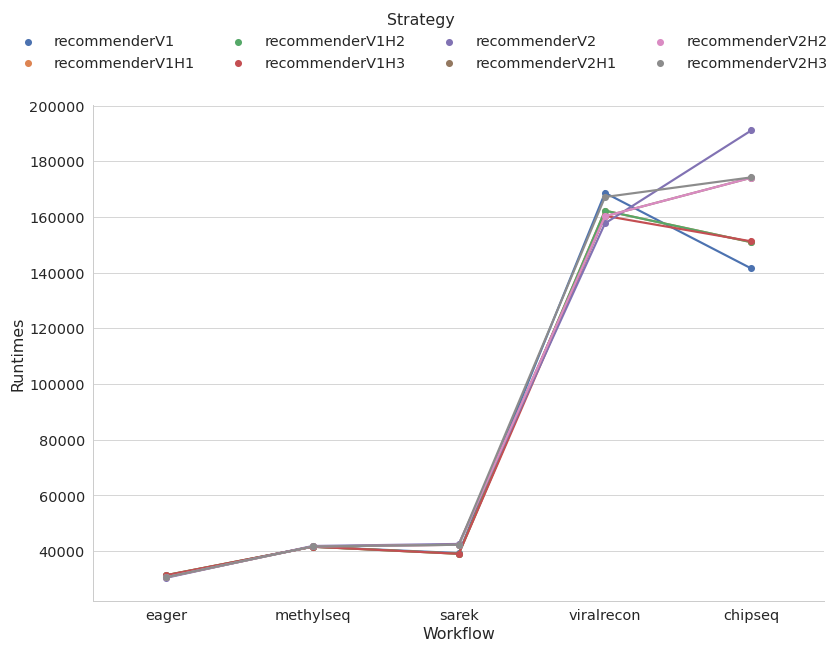

In [129]:
g = sns.catplot(x="wfName", y="res",  # orient="h",
                order=["eager", "methylseq", "sarek", "viralrecon", "chipseq"],
                hue="method",  # palette=["m", "g"],
                hue_order=["recommenderV1", "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2", "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # row="wfName",
                # col="wfName",
                # col_wrap=3,
                data=cvBigtable[cvBigtable.schedCat != "random"],
                kind="point",
                aspect=1.5,
                height=8,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.425, 1), ncol=4, title="Strategy", frameon=False)
g.set(xlabel="Workflow", ylabel="Runtimes")
save_plot(g, "cv.res_Vs_method_bisModel_Point.plot")
plt.show()

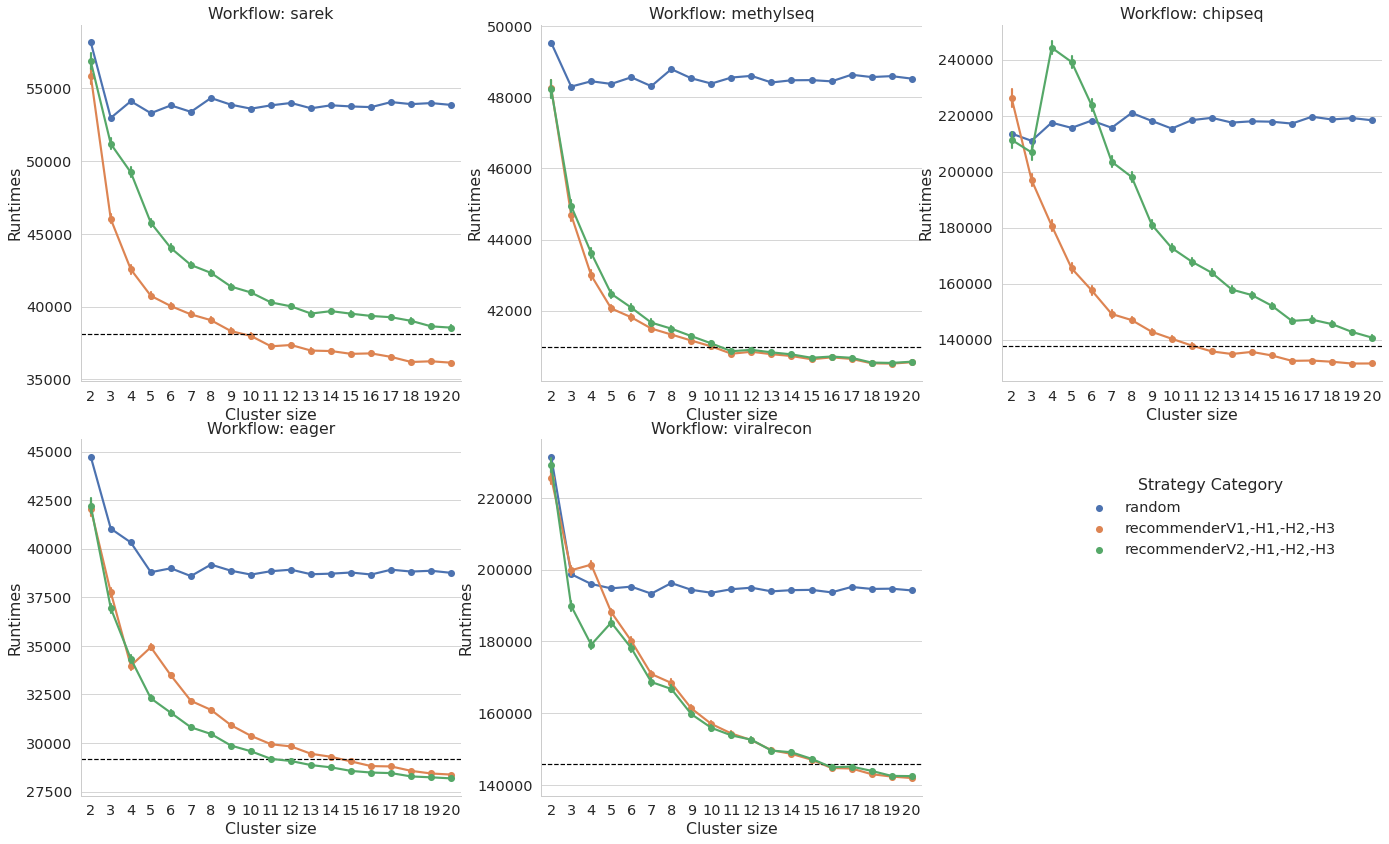

In [130]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="schedCat",  # palette=["m", "g"],
                # row="wfName",
                col="wfName",
                col_wrap=3,
                col_order=list(wfNames),
                sharey=False,
                sharex=False,
                data=cvBigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "upper left", bbox_to_anchor=(.65, .45), title="Strategy Category", frameon=False)
for i, ax in enumerate(g.axes.ravel()):
    wf = list(wfNames)[i]
    ax.axhline(y=statistics.mean(cvBigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), linestyle="--", color="black")
g.set_titles("Workflow: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "cv.res_Vs_clusterSize_perWF_bisModel_hueSchedCat_Point.plot")
plt.show()

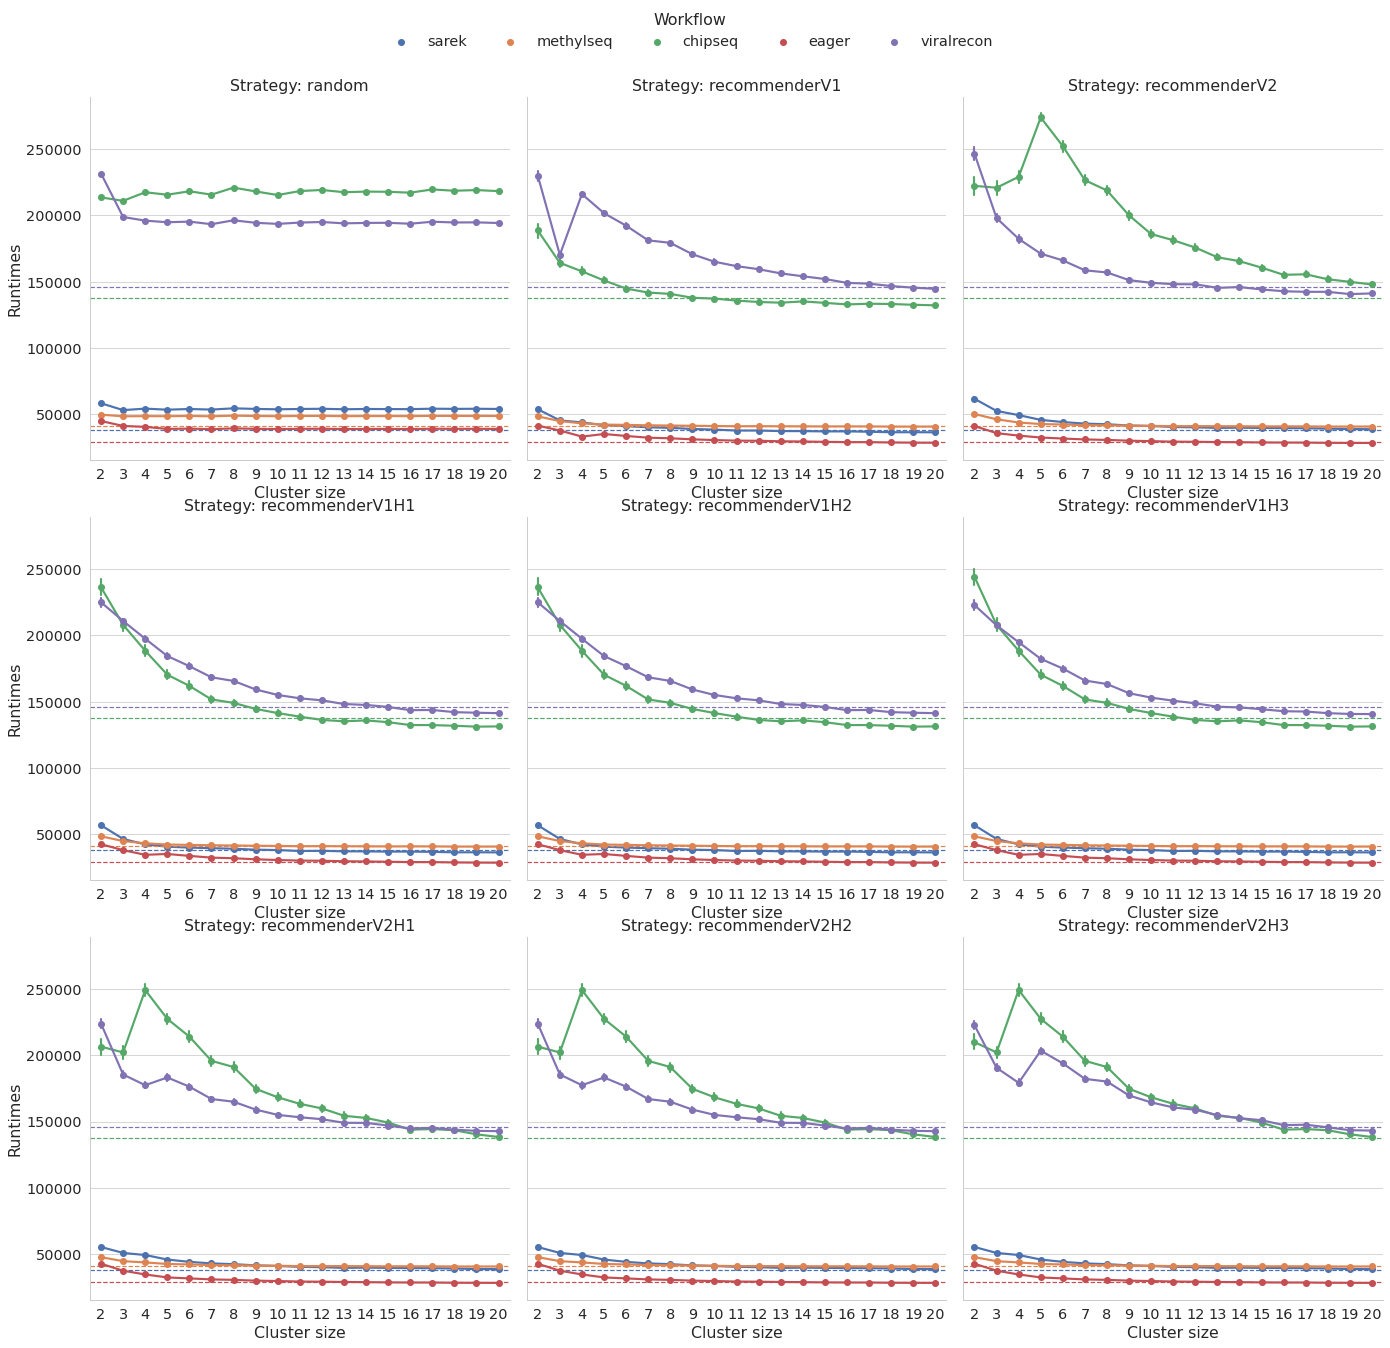

In [131]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="wfName",  # palette=["m", "g"],
                # row="wfName",
                col="schedType",
                col_wrap=3,
                col_order=["random", "recommenderV1", "recommenderV2",
                           "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # sharey=False,
                sharex=False,
                hue_order=list(wfNames),
                data=cvBigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.45, 1), ncol=5, title="Workflow", frameon=False)
for i, wf in enumerate(wfNames):
    g.refline(y=statistics.mean(cvBigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), color=sns.color_palette()[i])
g.set_titles("Strategy: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "cv.res_Vs_clusterSize_perMethod_bisModel_hueWf_Point.plot")
plt.show()
